# Explanatory models for time series data

We will be looking at a modelling methodology for creating *explanatory* models for time series data. I emphasise the 'explanatory' part because we are differentiating these models, whose purpose is to say something about the factors that drive the time series, for other types of models with different purposes,for example to forecast the time series, to spot anomalies in processes etc. We will cover:

1. The method I use to build a econometric model for a time series. We will use a very simple artificial example but one that is complex enough to bring out the kind of issues you will come across in the real applications.
2. A more rough and ready approach, based on the kind of filtering that is done in signal processing. This approach might be worth considering if you need to automate large numbers of models (say across many products or keywords).
3. An introduction to mixed effects models, which should be very useful if you wish to create hierarchical models.

We won't be discussing much of the theory when looking at regression (as I'm assuming you are all reasonably familiar with this) but we will touch on the theory for mixed effects models. It is a bit different (and interesting!)

We begin, as usual, by simulating some data.

## Simulating some time series data

### Set up the environment

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
from statsmodels.regression.mixed_linear_model import MixedLMParams
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_white

plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
num_time_periods = 3*365

### Creating a time series of searches for the keyword "video game"

Here we simulate some data on searches for the keyword 'video game'. You may like to return to this code but skip it for now as it is better for the exercises that follow if you don't know how the series is constructed.

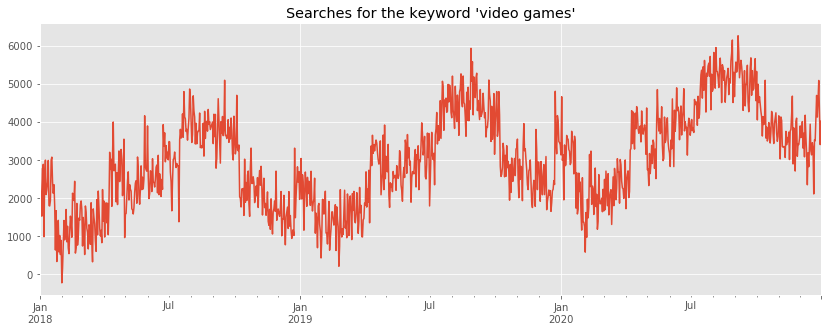

In [2]:
np.random.seed(123)
date_index = pd.date_range('2018-01-01', periods = num_time_periods, freq = 'D')
x = np.linspace(-np.pi, 5*np.pi, num_time_periods)
temp = (np.sin(x+1) + np.random.normal(0,0.5,num_time_periods))*10 + 10
x = np.linspace(0, 0.2, num_time_periods)
trend = x**2
holidays = [1]*21 + [0]*77 + [1]*21 + [0]*77 + [1]*84 + [0]*77 + [1]*8
holidays = np.array(holidays + holidays + holidays)

event_group = []
event_group_nc = []

for t in range(3):

    events = [0]*num_time_periods
    event_dates = np.random.randint(0,num_time_periods, 20)
    for e in event_dates:
        events[e] = np.asscalar(np.random.randint(1,10, 1))

    events_with_carry_over = [0]
    for e in range(num_time_periods):
        events_with_carry_over.append(events[e] + 0.6*events_with_carry_over[e])
    
    events_with_carry_over = np.array(events_with_carry_over[0:num_time_periods])
    event_group.append(pd.Series(events_with_carry_over).shift(-1).fillna(0).values)
    event_group_nc.append(events)
  
intercept = 1000
temp_coef = 90
holidays_coef = 1000
trend_coef = 50000
events_coef_1 = 100
events_coef_2 = 50
events_coef_3 = 150

video_game_searches = (intercept + temp_coef*temp + trend_coef*trend + holidays_coef*holidays 
    + events_coef_1*event_group[0]
    + events_coef_2*event_group[1]
    + events_coef_3*event_group[2]
    + np.random.normal(0,100, num_time_periods))

video_game_searches = pd.Series(video_game_searches, index=date_index)
fig, ax = plt.subplots(figsize = (14,5))
ax = video_game_searches.plot(title = "Searches for the keyword 'video games'")

### Simulating searches within a keyword group

Here we are simulating ten separate time series that are related in that they are all for words that are connected with gaming. We'd expect the same causes to be at work for each of them although there will be differences too.

In [3]:
related_ts = []

rand_intercept = np.random.normal(intercept, 100, 10)
rand_temp_coef = np.random.normal(temp_coef, 100, 10)
rand_holidays_coef = np.random.normal(holidays_coef, 200, 10)
rand_trend_coef = np.random.normal(trend_coef, 50000, 10)
rand_events_coef_1 = np.random.normal(events_coef_1, 100, 10)
rand_events_coef_2 = np.random.normal(events_coef_2, 100, 10)
rand_events_coef_3 = np.random.normal(events_coef_3, 100, 10)

for i in range(10):
    
    searches = (rand_intercept[i] + rand_temp_coef[i]*temp + rand_trend_coef[i]*trend + rand_holidays_coef[i]*holidays + 
                rand_events_coef_1[i]*event_group[0] + rand_events_coef_2[i]*event_group[1] + 
                rand_events_coef_3[i]*event_group[2] + np.random.normal(0,100, num_time_periods))
    related_ts.append(pd.Series(searches, index=date_index))
    

In [82]:
keywords = ["first person shooter", "xbox one", "playstation", "multiplayer games", "third person shooter", 
            "open world game", "rpg", "nintendo switch", "arcade games", "fantasy games"]
hier_model_set = pd.DataFrame()
for i in range(10):
    subset = pd.DataFrame({"keyword":keywords[i], "time_period": list(range(num_time_periods)), "searches": related_ts[i],
                           "temp": temp, "holidays": holidays, "big_game_release": event_group[0], "comic_con": event_group[1],
                           "console_release": event_group[2]})
    hier_model_set = hier_model_set.append(subset)
hier_model_set.head()

,big_game_release,comic_con,console_release,holidays,keyword,searches,temp,time_period
2018-01-01,0.00,0.00,0.00,1,first person shooter,1509.38,-3.84,0
2018-01-02,0.00,0.00,0.00,1,first person shooter,2993.35,6.48,1
2018-01-03,0.00,0.00,0.00,1,first person shooter,2254.26,2.82,2
2018-01-04,0.00,0.00,0.00,1,first person shooter,898.38,-6.21,3
2018-01-05,0.00,0.00,0.00,1,first person shooter,1763.57,-1.66,4


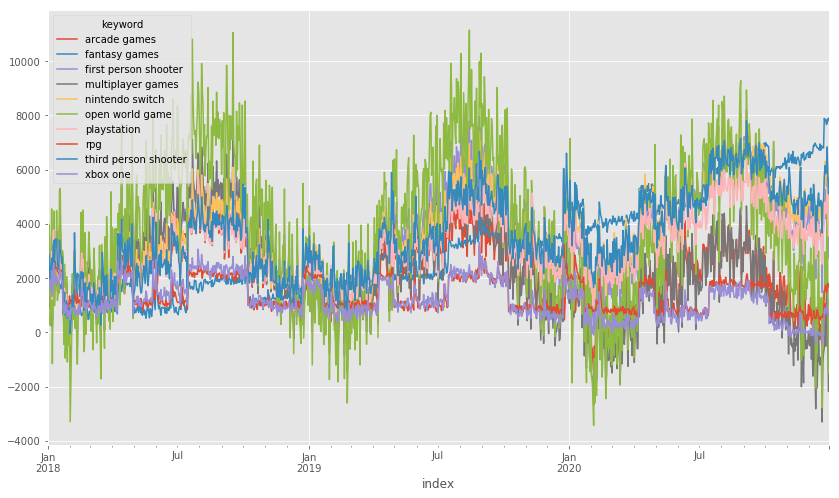

In [5]:
fig, ax = plt.subplots(figsize = (14,8))
_ = hier_model_set.reset_index().groupby(['index','keyword']).sum()['searches'].unstack().plot(ax = ax)

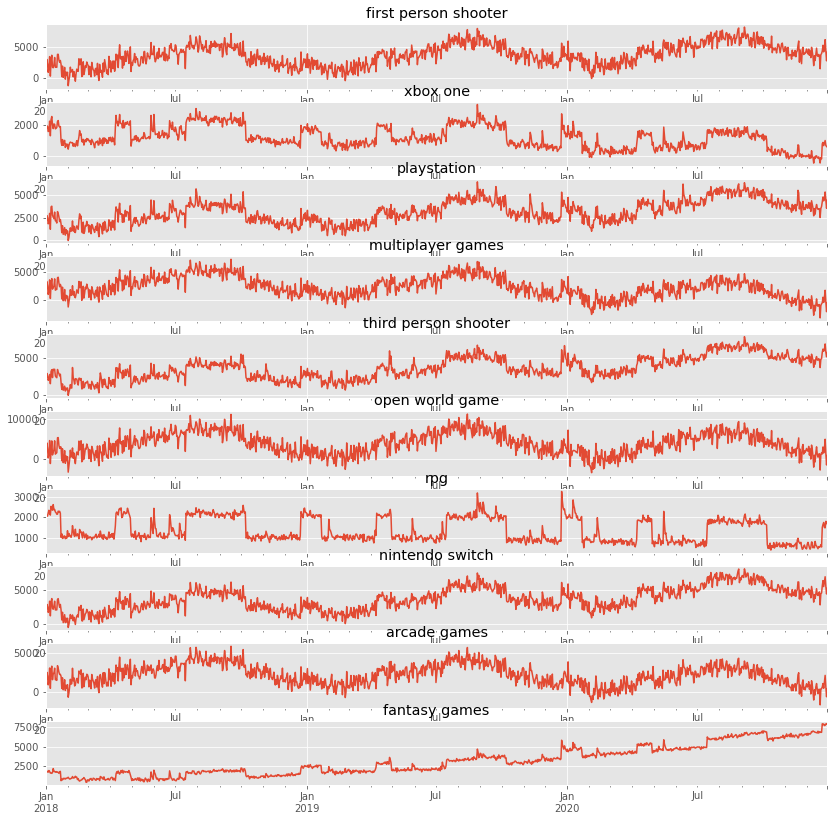

In [7]:
fig = plt.figure(figsize = (14,14))

for i, e in enumerate(keywords):
    ax_1 = fig.add_subplot(10,1,i+1)
    hier_model_set[hier_model_set.keyword == e]['searches'].plot()
    plt.title(e)

## The econometrician's approach to building an explanatory model

In this exercise we are modeling a time series that describes, at a daily level, the number of searches submitted to a search engine for the keyword "video game". The purpose of the project is to alert businesses that might be prepared to bid on this keyword to  periods of high demand and their causes. For example we might say that school holidays are a boom period for searches on that keyword, and therefore prices will drop and it is worth adjusting campaign plans accordingly. 

We are going to assume that we've completed the preliminary steps of the project. These would be:

1. Clearly defining the project objectives in business terms and explaining how these objectives map onto the analytical work. 
2. Creating a causal model that explains how the drivers of the modelled time series interact with each other.
3. Assembling a data set containing variables that describe the drivers (or that are proxies for the drivers - it's important to take note of where a variable is a proxy)
4. Transforming some of these variables (log, exp, powers, lags, leads, smoothing) where there exists a good reason for doing so. 
4. Some exploratory data analysis where the key features of the modelled time series and the explanatory variables are surfaced and discussed. 

**Pause here to discuss which of these steps have already been taken in current projects and how they might apply to this exercise**

We will do a quick plot of our assembled data set to get a rough idea of the kind of conclusions we would have reached in step 5.

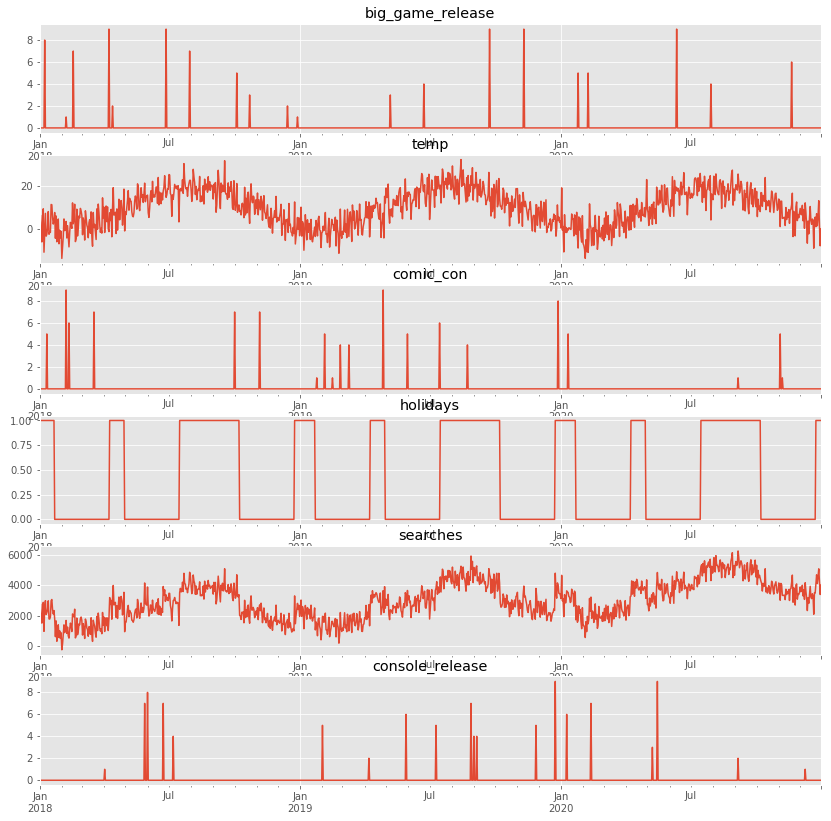

In [8]:
model_set = pd.DataFrame({"searches": video_game_searches, "time_period": list(range(num_time_periods)), "temp": temp, 
                          "holidays": holidays, "big_game_release": event_group_nc[0],
                             "comic_con": event_group_nc[1],"console_release": event_group_nc[2]})
fig = plt.figure(figsize = (14,14))
exp_vars = {"searches", "big_game_release","comic_con","console_release","holidays","temp"}
for i, e in enumerate(exp_vars):
    ax_1 = fig.add_subplot(6,1,i+1)
    model_set[e].plot()
    plt.title(e)

The next step is to fit the model. It is possible to use a feature selection technique such the stepwise algorithm to determine which variables go in the model but this usually means bypassing some important findings. I recommend a bottom up approach for instead, adding features in the order of their probable impact.

### Adding a trend

A first step might be to add a trend variable. The principle of parsimony says start simple, so we begin with a linear trend.

In [9]:
md = smf.ols(formula = 'searches ~ time_period', data = model_set)
res = md.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     434.6
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           1.61e-81
Time:                        16:38:29   Log-Likelihood:                -9160.4
No. Observations:                1095   AIC:                         1.832e+04
Df Residuals:                    1093   BIC:                         1.833e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1856.1791     62.858     29.530      

The both the trend coefficient and the intercept coefficient are (unsurprisingly) sigficant. There is no point doing much else at the moment because we know we have some major drivers to add to take care of the among other things the seasonal patterns. But I do want to log, for reasons that will become apparent, the AIC of the model.

In [10]:
modelling_history = []
modelling_history.append({"model desc": "trend only", "AIC": res.aic, "comments": "none"})

### Adding seasonality

Next I want to deal with the seasonality. We have a temperature variable that might help us here. But we need to ask: what is the role of the temperature? Is it a direct driver of searches? Our causal model suggests a direct mechanism where if it is too cold people will stay indoors and search on the computer. So it is kind of a proxy for bad weather overall. But there is another purpose for which we might be using it. Seasonality isn't just about direct causal effects. When it is summer and temperatures rise in general we make more outdoor plans. I may make a plan a week ahead because I think it will probably be hot. I don't then change those plans on the day just because it is a little colder than expected. This suggests that I should smooth the temperature time series before applying it. We can try both approaches. First we use a localised regression technique to smooth the temperature data.

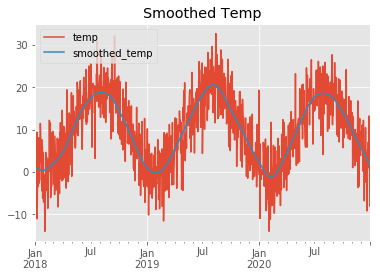

In [11]:
from statsmodels.nonparametric.kernel_regression import KernelReg
kr = KernelReg(model_set.temp.values, model_set.time_period.values, 'c')
y_pred, y_std  = kr.fit(model_set.time_period.values)
model_set = model_set.assign(smoothed_temp = y_pred)
_ = model_set[['temp', 'smoothed_temp']].plot(title = "Smoothed Temp")

Next we try the two alternatives: smoothed and raw temperature data.

In [12]:
md = smf.ols(formula='searches ~ time_period + temp', data = model_set)
res_raw = md.fit() 
print(res_raw.summary())

md = smf.ols(formula='searches ~ time_period + smoothed_temp', data = model_set)
res_smoothed = md.fit()
print(res_smoothed.summary())

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     2383.
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:40:22   Log-Likelihood:                -8423.9
No. Observations:                1095   AIC:                         1.685e+04
Df Residuals:                    1092   BIC:                         1.687e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     999.2640     35.595     28.073      

The unsmoothed data works best. But it may be that is just because we haven't taken care other effects. We log both options in our history. These small decisions by the modeller can have a big impact later. We need to guard against *Researcher Degrees of Freedom*.

In [13]:
modelling_history.append({"model desc": "trend and raw temp", "AIC": res_raw.aic, "comments": 
                          "The raw temperature data resulted in a slightly better fit compared to smoothed temperature"})

modelling_history.append({"model desc": "trend and smoothed temp", "AIC": res_smoothed.aic, "comments": 
                          "Re-visit the smoothed temp option later"})

Having taken care of seasonality it now makes sense to start looking at the residuals

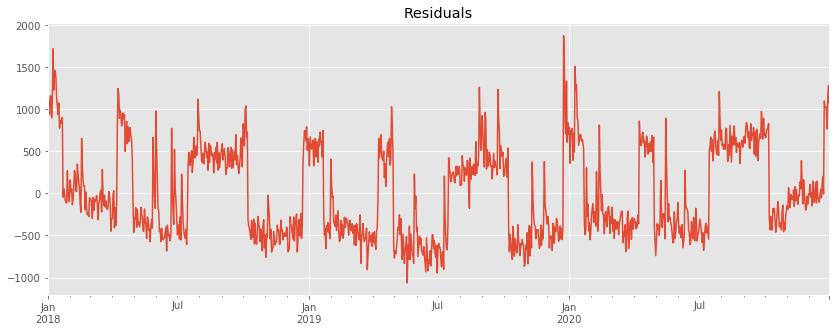

In [14]:
fig, ax = plt.subplots(figsize = (14,5))
ax = res_raw.resid.plot(title = "Residuals")

Clearly we are still a long way from white noise! We see that there seem to be substantial lifts in search volumes in periods that correspond to the school holidays. Let's add that to the model.

### Adding the school holidays

In [15]:
md = smf.ols(formula = 'searches ~ time_period + temp + holidays', data = model_set)
res_hol = md.fit() 
print(res_hol.summary())

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     8418.
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:42:14   Log-Likelihood:                -7600.4
No. Observations:                1095   AIC:                         1.521e+04
Df Residuals:                    1091   BIC:                         1.523e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     767.7033     17.199     44.636      

All variables have significant coefficients and the AIC has dropped even further. We record the model. We should start looking at the improvements to AIC. They should be dramatic at first and then start to tail off. When they become negligible we should start to worry about overfitting.

In [17]:
modelling_history.append({"model desc": "trend, temp and holidays", "AIC": res_hol.aic, "comments": "None"})

modelling_history_df = pd.DataFrame(modelling_history)
modelling_history_df

,AIC,comments,model desc
0,18324.86,none,trend only
1,16853.88,The raw temperature data resulted in a slightl...,trend and raw temp
2,17440.64,Re-visit the smoothed temp option later,trend and smoothed temp
3,15208.75,None,"trend, temp and holidays"


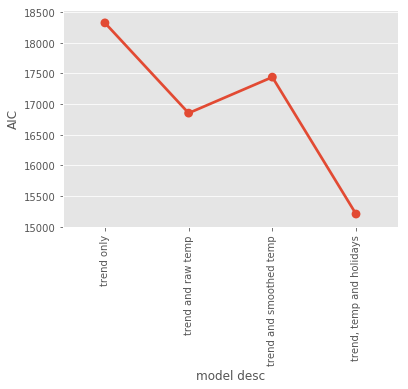

In [18]:
g = sns.pointplot(x = "model desc", y = "AIC", data = modelling_history_df)
_ = plt.xticks(rotation = 90)

Next let's take a look at the residuals.

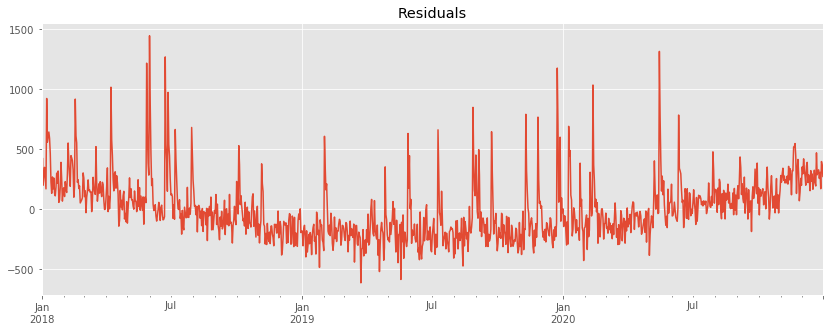

In [16]:
fig, ax = plt.subplots(figsize = (14,5))
ax = res_hol.resid.plot(title = "Residuals")

The residuals are starting to look more like white noise. But there is clearly something major wrong here. Why do they have this bowed pattern? The curved shape looks like evidence of some kind of model misspecification. Most likely we are have got the wrong kind of trend. Let's try a polynomial.

### Revisiting the trend

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.365e+04
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:45:03   Log-Likelihood:                -6970.6
No. Observations:                1095   AIC:                         1.396e+04
Df Residuals:                    1088   BIC:                         1.399e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1048.9129      8.174  

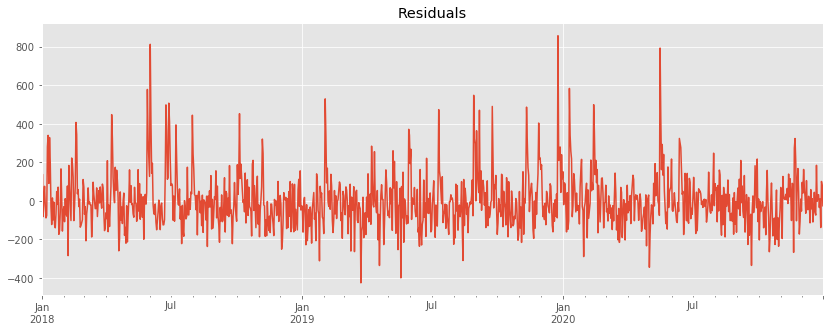

In [20]:
model_set = model_set.assign(sq_trend = model_set.time_period*model_set.time_period)
md = smf.ols(formula='searches ~ sq_trend + temp + holidays + comic_con + big_game_release + console_release', data=model_set)
res_sq_trend = md.fit()
print(res_sq_trend.summary())
fig, ax = plt.subplots(figsize = (14,5))
ax = res_sq_trend.resid.plot(title = "Residuals")

This seems to have worked. Once again we log the model and examine the AIC in context.

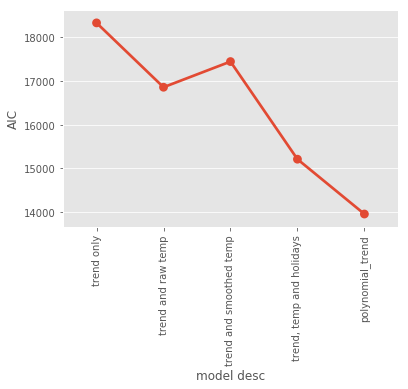

In [21]:
modelling_history.append({"model desc": "polynomial_trend", "AIC": res_sq_trend.aic, "comments": "None"})

modelling_history_df = pd.DataFrame(modelling_history)
g = sns.pointplot(x = "model desc", y = "AIC", data = modelling_history_df)
_ = plt.xticks(rotation = 90)

### Adding the events

I know that there are various events (big game releases, comic con, console releases) that probably explain any remaining patterns in the residuals. 

In [24]:
md = smf.ols(formula = 'searches ~ sq_trend + temp + holidays + comic_con + big_game_release + console_release', data = model_set)
res_events = md.fit()
print(res_events.summary())
modelling_history.append({"model desc": "Added all events", "AIC": res_events.aic, "comments": "None"})

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.365e+04
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:47:04   Log-Likelihood:                -6970.6
No. Observations:                1095   AIC:                         1.396e+04
Df Residuals:                    1088   BIC:                         1.399e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1048.9129      8.174  

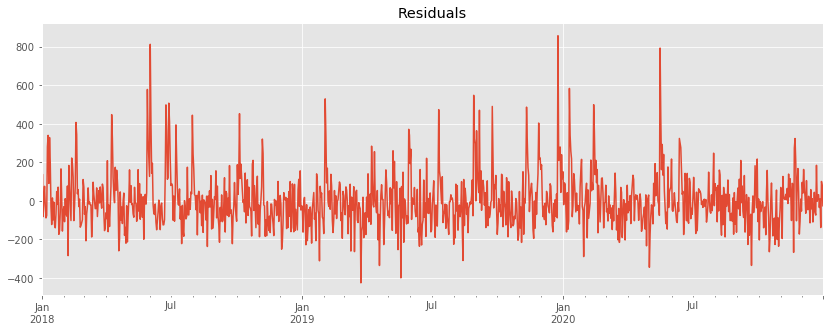

In [25]:
fig, ax = plt.subplots(figsize = (14,5))
ax = res_events.resid.plot(title = "Residuals")

I want to know whether these events had any carryover effect on searches. I need to create some lagged variables to test this idea.

In [26]:
for v in ["comic_con", "big_game_release", "console_release"]:
    for l in range(3):
        new_var = v + "_lag_" + str(l+1)
        model_set[new_var] = model_set[v].shift(l+1).fillna(0)

First I'll try adding a single lag.

In [28]:
md = smf.ols(formula = 'searches ~ sq_trend + temp + holidays + comic_con + comic_con_lag_1 + \
                      big_game_release + big_game_release_lag_1 + console_release + console_release_lag_1', data = model_set)
res_events_co = md.fit()
print(res_events_co.summary())

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.391e+04
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:48:57   Log-Likelihood:                -6739.3
No. Observations:                1095   AIC:                         1.350e+04
Df Residuals:                    1085   BIC:                         1.355e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1028

Clearly there are some carry over effects. It makes sense too that they are lower than the original effects. Let's look at how far they might extend after the event.

In [29]:
md = smf.ols(formula='searches ~ sq_trend + temp + holidays + comic_con + comic_con_lag_1 + comic_con_lag_2 + comic_con_lag_3 + \
             big_game_release + big_game_release_lag_1 + big_game_release_lag_2 + big_game_release_lag_3 + \
             console_release + console_release_lag_1 + console_release_lag_2 + console_release_lag_3', data = model_set)
res_events_co_3 = md.fit()
print(res_events_co_3.summary())

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        16:49:38   Log-Likelihood:                -6585.8
No. Observations:                1095   AIC:                         1.320e+04
Df Residuals:                    1079   BIC:                         1.328e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1010

Although they pass the hypothesis tests do the additional lags lead to substantive improvements in the model? It's time to look again at AIC.

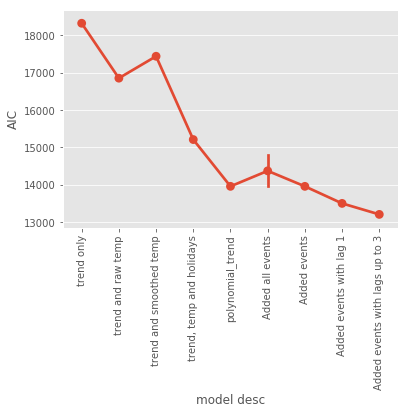

In [30]:
modelling_history.append({"model desc": "Added events with lag 1", "AIC": res_events_co.aic, "comments": "None"})

modelling_history.append({"model desc": "Added events with lags up to 3", "AIC": res_events_co_3.aic, "comments": "None"})

modelling_history_df = pd.DataFrame(modelling_history)
g = sns.pointplot(x = "model desc", y = "AIC", data = modelling_history_df)
_ = plt.xticks(rotation = 90)

As we expected AIC is bottoming out. We should be very cautious from here on in. 

We can now start to take the residuals more seriously. Only now does it makes sense to do some statistical tests that look at autocorrelation and hetereoskedasticity.

### Testing the model assumptions

The Ljungbox tests allows us to test the null hypothesis that there is no autocorrelation up to a certain number of lags. Here it is up to 20 lags.

In [34]:
pprint(acorr_ljungbox(res_events_co_3.resid)[1][1:20])

array([ 0.20190594,  0.0188112 ,  0.02888711,  0.03962832,  0.05524008,
        0.08248053,  0.10085909,  0.10975801,  0.06279237,  0.09029267,
        0.1270231 ,  0.10447117,  0.14074236,  0.0787858 ,  0.09222096,
        0.0831776 ,  0.11049276,  0.0778266 ,  0.05296712])


This looks passable although there does seem to be some evidence of remaining autocorrelation. Next we do White's test where the null hypothesis is that the residuals exhibit a constant variance.

In [ ]:
p_value = het_white(res_events_co_3.resid, res_events_co_3.model.exog)[3]
print(p_value)

Next we use VIF to check for multicolinearity.

>In statistics, the variance inflation factor (VIF) is the ratio of variance in a model with multiple terms, divided by the variance of a model with one term alone.[1] It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity... The square root of the variance inflation factor indicates how much larger the standard error is, compared with what it would be if that variable were uncorrelated with the other predictor variables in the model.

Wikipedia

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
exp_vars = model_set.drop(['searches', 'time_period', 'smoothed_temp'], axis = 1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(exp_vars.values, i) for i in range(exp_vars.shape[1])]
vif["variable"] = exp_vars.columns
vif

,VIF,variable
0,1.01,big_game_release
1,1.02,comic_con
2,1.02,console_release
3,1.62,holidays
4,1.99,temp
5,1.59,sq_trend
6,1.02,comic_con_lag_1
7,1.01,comic_con_lag_2
8,1.01,comic_con_lag_3
9,1.01,big_game_release_lag_1


We've clearly got nothing to worry about here.

Our model passes the tests for multicolinearity and heteroskedasticity although there still seems to be some evidence for autocorrelation. That said a visual inspection of the residuals shows that is not serious. At this point we might rest satisfied. But here is where we should be alert to human biases. We should be reviewing our work and trying to catch ourselves out. Several things worry me:

1. To what extent are any conclusions I am interested in dependent on decisions I might have made early on in the modelling process?
2. Are there alternative models that are just as good as the model I have created, but lead to different conclusions. (The Rashomon effect)
4. To what extent might I have overfitted my model? (bootstrapping and CV)

### Stress testing the model

Addressing the first point

Let's imagine that the thing that we are most interested in at the moment is the effect of big game releases. Our model says that the contribution to search on the day of release is 96 * the number of sales of the game on the day of release. But we made several decision down the line that might effect this. For example we chose to use raw temp data. Let's sensitivity test the impact of this decision.


In [56]:
model_set = model_set.assign(sq_trend = model_set.time_period*model_set.time_period)
md = smf.ols(formula = 'searches ~ sq_trend + smoothed_temp + holidays + comic_con + comic_con_lag_1 + comic_con_lag_2 + \
             comic_con_lag_3 + big_game_release + big_game_release_lag_1 + big_game_release_lag_2 + big_game_release_lag_3 + \
             console_release + console_release_lag_1 + console_release_lag_2 + console_release_lag_3', data = model_set)
res_sq_trend = md.fit()
print(res_sq_trend.summary())

                            OLS Regression Results                            
Dep. Variable:               searches   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     470.3
Date:                Wed, 13 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:23:56   Log-Likelihood:                -8237.8
No. Observations:                1095   AIC:                         1.651e+04
Df Residuals:                    1079   BIC:                         1.659e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                961

A drop from 96 to 80 might be considered problematic, depending on the decison being taken. We should repeat this for other decision we have made.

### The Rashomon effect 

To address point 2 I use a brute force method to search the space of possible models, tracking AIC to see if any other models are comparable. This is not possible once the number of variables gets large. If that happens a search algorithm like stepwise will be needed.

In [59]:
from itertools import combinations

def subsets(s):
    for cardinality in range(len(s) + 1):
        yield from combinations(s, cardinality)

s = model_set.columns.tolist()
s = [x for x in s if x not in ["searches", "temp", "sq_trend", "smoothed_temp", "time_period"]]
sub_sets = [list(sub_set) for sub_set in subsets(s)]
other_models = []
for m in sub_sets[1:]:
    formula = "searches ~ temp + sq_trend + {}".format(' + '.join(m))
    fitted = smf.ols(formula, model_set).fit()
    if fitted.aic < 13500:
        other_models.append({"formula": formula, "aic": fitted.aic, "big_game_release":fitted.params["big_game_release"]})

We can plot the AICs of all competing models and look at the impact on the estimate for big_game_release.

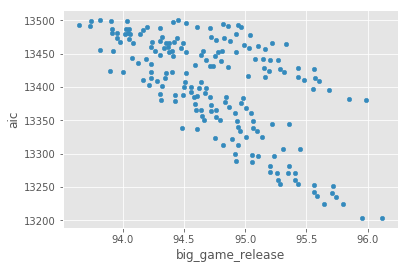

In [60]:
other_models_df = pd.DataFrame(other_models)
_ = other_models_df.plot.scatter(y = "aic", x = "big_game_release")

All comparable models give estimates of big_game_release that are similar to our chosen model. 

### Bootstrapping AIC

Next we address the issue of overfitting. We have chosen the model with three lag terms because it has a lower AIC. But is the AIC really better or is this down to chance (the AIC is after all a random variable itself). Here we bootstrap the difference in AIC to understand if the improvement was significant

In [61]:
bs_aic = []
num_boot = 1000
formula_a = 'searches ~ sq_trend + temp + holidays + comic_con + comic_con_lag_1 + comic_con_lag_2 + comic_con_lag_3 + \
             big_game_release + big_game_release_lag_1 + big_game_release_lag_2 + big_game_release_lag_3 + \
             console_release + console_release_lag_1 + console_release_lag_2 + console_release_lag_3'

formula_b = 'searches ~ sq_trend + temp + holidays + comic_con + comic_con_lag_1 + big_game_release + big_game_release_lag_1 + \
             console_release + console_release_lag_1'

for i in range(num_boot):
    boot_model_set = model_set.sample(num_time_periods, replace = True)
    aic_a = smf.ols(formula_a, boot_model_set).fit().aic
    aic_b = smf.ols(formula_b, boot_model_set).fit().aic
    bs_aic.append(aic_a - aic_b)

The difference in AIC is not plausibly zero so we are justified in taking the model with three lag terms.

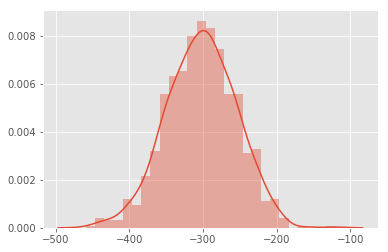

In [62]:
_ = sns.distplot(bs_aic)

### Predictive power

As a final check we could ask whether the additional lagged terms result in an increase in predictive power.

In [63]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = model_set[["sq_trend", "temp", "holidays", "comic_con", "big_game_release", "console_release", "comic_con_lag_1",
               "big_game_release_lag_1", "console_release_lag_1", "comic_con_lag_2", "big_game_release_lag_2",
               "console_release_lag_2", "comic_con_lag_3","big_game_release_lag_3", "console_release_lag_3"]].values
y = model_set['searches'].values
kf = KFold(n_splits = 10) 

mse_m1 = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse_m1.append(mean_squared_error(y_test, y_pred))
    
mse_m2 = []

X = model_set[["sq_trend","temp","holidays","comic_con","big_game_release","console_release", "comic_con_lag_1",
               "big_game_release_lag_1","console_release_lag_1"]].values
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse_m2.append(mean_squared_error(y_test, y_pred))

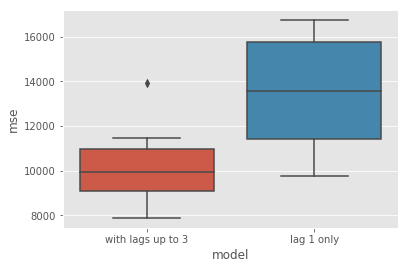

In [65]:
comp_mse_1 = pd.DataFrame({"model": "with lags up to 3", "mse": mse_m1})
comp_mse_2 = pd.DataFrame({"model": "lag 1 only", "mse": mse_m2})
comp_mse = comp_mse_1.append(comp_mse_2)
ax = sns.boxplot(x = "model", y = "mse", data = comp_mse)

It's clear that adding additional lags reduces the MSE.

## A signal processing approach

It may not be feasible to hand craft a model for each time series. If this is the case then it may be worth considering using filters to extract the trend and seasonal patterns. This cuts out some of the work.

Here we use an HP filter to de-trend and de-seasonalise the data.

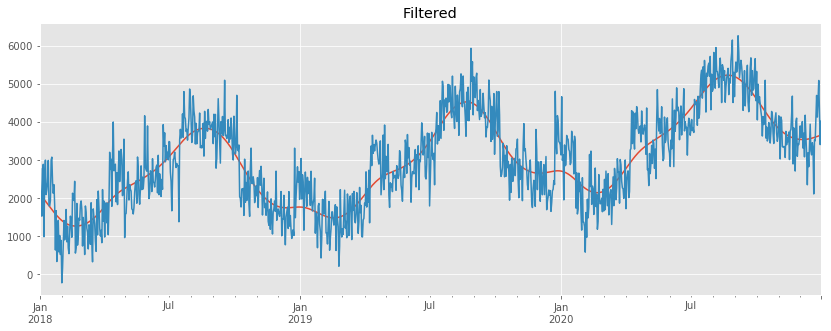

In [66]:
import statsmodels.api as sm
tsa = sm.tsa
searches_cycle, searches_trend = tsa.filters.hpfilter(model_set.searches, lamb = 129600)
fig, ax = plt.subplots(figsize = (14,5))
ax = searches_trend.plot(title = "Filtered")
ax = model_set.searches.plot()

This gives us a time series of residuals to model.

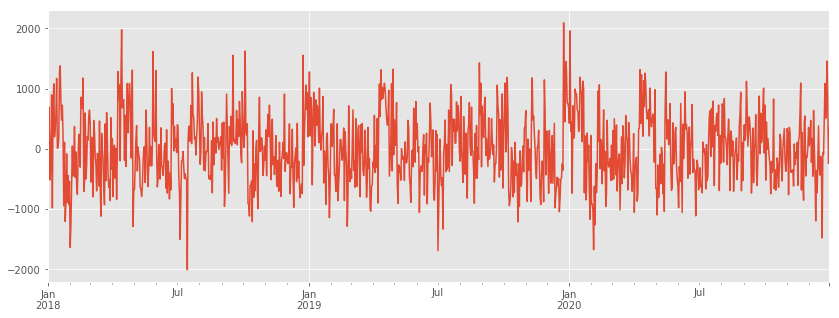

In [67]:
model_set = model_set.assign(detrended_searches = model_set.searches - searches_trend)
fig, ax = plt.subplots(figsize = (14,5))
ax = model_set.detrended_searches.plot()

In [68]:
md = smf.ols(formula = 'detrended_searches ~ holidays + comic_con + comic_con_lag_1 + comic_con_lag_2 + comic_con_lag_3 + \
             big_game_release + big_game_release_lag_1 + big_game_release_lag_2 + big_game_release_lag_3 + \
             console_release + console_release_lag_1 + console_release_lag_2 + console_release_lag_3', data = model_set)
res_detrend = md.fit()
print(res_detrend.summary())

                            OLS Regression Results                            
Dep. Variable:     detrended_searches   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     35.88
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           3.42e-75
Time:                        17:38:17   Log-Likelihood:                -8321.4
No. Observations:                1095   AIC:                         1.667e+04
Df Residuals:                    1081   BIC:                         1.674e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -264

How well does the filtering approach match the full model approach?

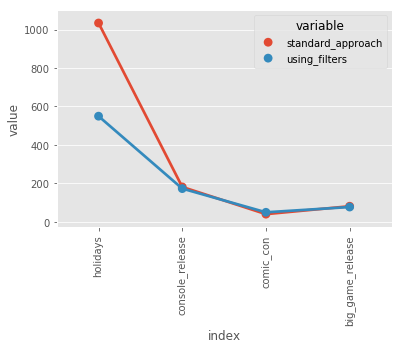

In [69]:
comp_coefs = pd.DataFrame({"using_filters":res_detrend.params[['holidays', 'console_release', 'comic_con', 'big_game_release']], "standard_approach": res_sq_trend.params[['holidays', 'console_release', 'comic_con', 'big_game_release']]})
comp_coefs = comp_coefs.reset_index().melt(id_vars = ['index'])
g = sns.pointplot(x = "index", y = "value", hue = "variable", data = comp_coefs)
_ = plt.xticks(rotation = 90)

Pretty well but whether it is good enough depends on the objective. 

## Mixed effects models

It seems wasteful to model separately a set of time series that should be related. This concern, among others is addressed when we use mixed effects models.

Simon will take you through some of the theory on the whiteboard, focusing on three key aspects of this technique.

1. How the mixed effects model allows you to combine the data from the individual time series into one overall model
2. How modelling some of the effects as random variables allows us to keep the number of parameters to be estimated very low.
3. How we are still able to provide estimates of effect at the level of each time series and how these estimates are *shrunk* towards the average effect.
4. How working with random effects amounts to the same thing as using a linear model with a modelled correlation structure for the error term.

Here is the code needed to carry out the mixed effects model on the video games keyword group.

In [91]:
import warnings
warnings.filterwarnings('ignore')

hier_model_set = hier_model_set.assign(trend_sq = hier_model_set.time_period**2)

free = MixedLMParams.from_components(
                 fe_params = np.ones(7),
                 cov_re = np.eye(7))

md = smf.mixedlm("searches ~ trend_sq + temp + holidays + big_game_release + console_release + comic_con", hier_model_set, groups=hier_model_set["keyword"],  
                 re_formula = "~trend_sq  + temp + holidays + big_game_release + console_release + comic_con")
mdf = md.fit(free = free)
print(mdf.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           searches   
No. Observations:             10950             Method:                       REML       
No. Groups:                   10                Scale:                        10137.3399 
Min. group size:              1095              Likelihood:                   -66382.4270
Max. group size:              1095              Converged:                    No         
Mean group size:              1095.0                                                     
-----------------------------------------------------------------------------------------
                                           Coef.   Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------------------------------------
Intercept                                  978.125   28.350 34.502 0.000 922.560 1033.691
trend_sq                            

The estimates for the random effects are:

In [92]:
random_effects = pd.DataFrame(mdf.random_effects).transpose()
random_effects

,Intercept,trend_sq,temp,holidays,big_game_release,console_release,comic_con
arcade games,26.03,-0.00,26.67,-362.96,48.99,-195.13,80.67
fantasy games,-115.71,0.00,-116.79,-103.04,-133.29,-4.64,-12.64
first person shooter,19.85,0.00,53.31,-28.52,5.03,30.89,-97.54
multiplayer games,-6.40,-0.00,65.19,45.80,-5.83,46.24,18.82
nintendo switch,7.76,0.00,9.24,262.29,26.87,35.57,-76.91
open world game,-126.02,-0.00,184.33,-1.82,-12.04,1.44,10.61
playstation,128.70,0.00,-19.25,-12.42,117.55,55.91,-16.60
rpg,85.81,-0.00,-104.62,57.79,-52.51,3.27,-30.49
third person shooter,76.20,0.00,-22.14,224.71,20.38,35.03,202.68
xbox one,-96.22,-0.00,-75.93,-81.84,-15.15,-8.58,-78.60


The final plot shows what a good job it does at modelling all 10 time series.

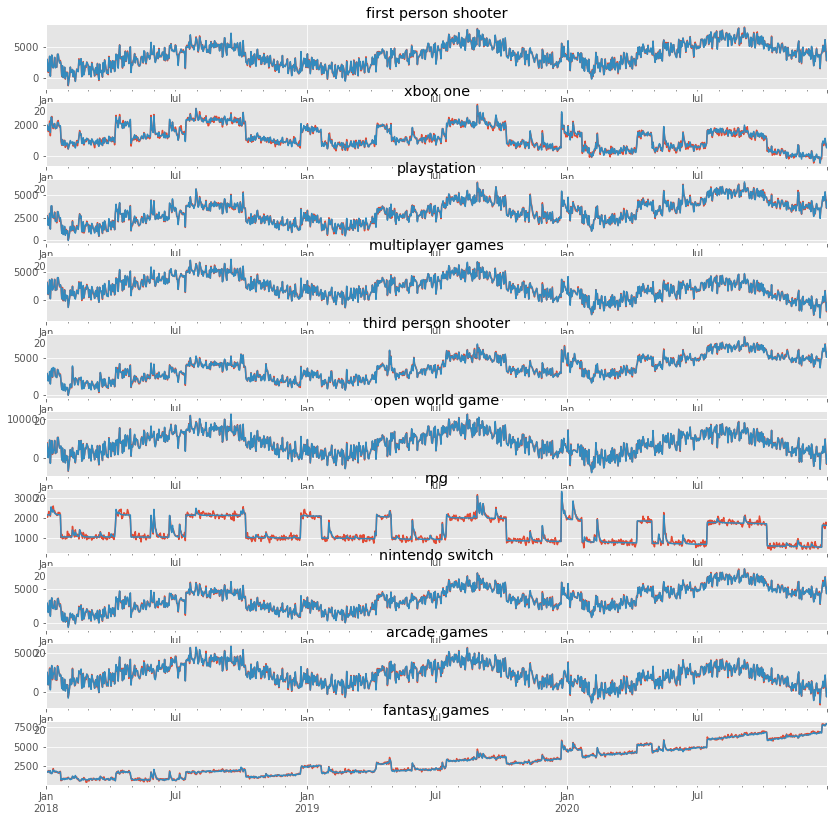

In [93]:
hier_model_set = hier_model_set.assign(fitted = mdf.fittedvalues)
fig = plt.figure(figsize=(14,14))
for i, e in enumerate(keywords):
    ax = fig.add_subplot(10,1,i+1)
    hier_model_set[hier_model_set.keyword == e]['searches'].plot(ax = ax)
    hier_model_set[hier_model_set.keyword == e]['fitted'].plot(ax = ax)
    plt.title(e)